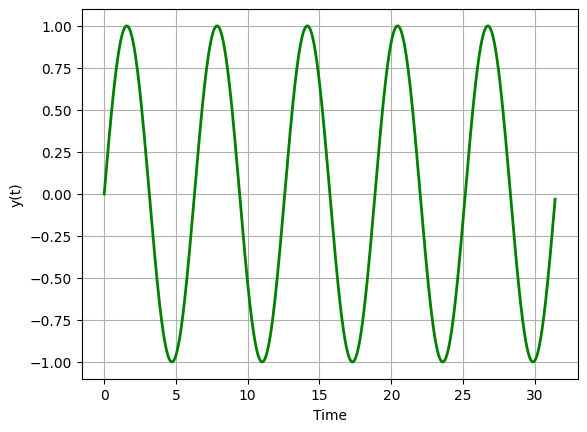

In [358]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [362]:
import pandas as pd
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import clip
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, text_samples):
        self.text_samples = text_samples
        self.tokenizer = clip.tokenize
    def __len__(self):
        return len(self.text_samples)

    def __getitem__(self, i):
        return self.tokenizer(self.text_samples[i])
        #torch.Size([1, 77])

# based on https://gist.github.com/srikarplus/8bdb5bedf0ca25e894e39ea78fce2f39
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      normalize])

    train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      normalize])
    
    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir, transform=train_transform,
    ) 
    # output : torch.tensor
    valid_dataset = datasets.ImageFolder(
        root=data_dir, transform=valid_transform,
    )
    
    
    num_train = len(train_dataset) # 2303
    indices = list(range(num_train)) # [0~ 2302]
    split = int(np.floor(valid_size * num_train)) # number of split


    ######### TEXT ##########
    data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')
    train_text_dataset=[]
    for i in range(num_train):
        img_dir =train_dataset.imgs[i][0].split('.jpg')[0].split('/')[-1]
        x_text = data[data['Id']==img_dir]['Title'].values[0]
        train_text_dataset.append(x_text)
        
    text_dataset = TextDataset(train_text_dataset)    
    ######### TEXT ##########
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices) # shuffle list

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    img_train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, # dataset 에서 train sampler를 통해서 나열된다.
        num_workers=num_workers, pin_memory=pin_memory,
    )
    
    text_train_loader = torch.utils.data.DataLoader(
        text_dataset, batch_size=batch_size, sampler=train_sampler, # dataset 에서 train sampler를 통해서 나열된다.
        num_workers=num_workers, pin_memory=pin_memory,
    )
    
    img_valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    text_valid_loader = torch.utils.data.DataLoader(
        text_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )


    # return (img_train_loader, img_valid_loader, train_dataset.class_to_idx)
    return (img_train_loader, img_valid_loader,text_train_loader, text_valid_loader,train_dataset.class_to_idx)
if __name__=='__main__':
    batch_size = 64
    PATH = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
    print(batch_size,PATH)
    
    img_train_loader, img_valid_loader,text_train_loader, text_valid_loader, class_idx = get_train_valid_loader(PATH, batch_size, False, 42, 0.1)
    # print(train_loader)


64 /Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/


In [383]:
from torch.utils.data import TensorDataset
TensorDataset(train_text_dataset)

AttributeError: 'list' object has no attribute 'size'

In [384]:
data_dir =  '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

# define transforms
valid_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    normalize])

train_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    normalize])

# load the dataset
train_dataset = datasets.ImageFolder(
    root=data_dir, transform=train_transform,
) 
# output : torch.tensor
valid_dataset = datasets.ImageFolder(
    root=data_dir, transform=valid_transform,
)


num_train = len(train_dataset) # 2303

data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')
train_text_dataset=[]
for i in range(num_train):
    img_dir =train_dataset.imgs[i][0].split('.jpg')[0].split('/')[-1]
    x_text = data[data['Id']==img_dir]['Title'].values[0]
    train_text_dataset.append(x_text)
    
text_dataset = TextDataset(train_text_dataset)    
######### TEXT ##########

In [400]:
train_dataset.loader

<function torchvision.datasets.folder.default_loader(path: str) -> Any>

In [395]:
torch.utils.data.ConcatDataset(train_dataset,text_dataset)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [394]:
for i in text_dataset:
    print(i.shape)
    ex1 = i
    break
ex1 = torch.randn(7,77)
ex2 = TensorDataset(ex1)

for ex in ex2:
    print(ex)
    
len(ex2)

torch.Size([1, 77])
(tensor([-2.2151,  0.4487, -0.7209, -0.5288, -0.3134,  0.8301,  0.4111,  0.4607,
         2.3378, -1.0587,  0.3869,  1.1700,  1.7866,  0.4223,  1.0794, -1.3185,
         2.2825,  0.6776,  0.0247,  0.1273, -0.6101,  0.8246, -0.2096,  0.2768,
        -0.9617,  0.5061,  1.4483, -0.8174, -1.9426, -0.8261,  0.2026, -2.1557,
        -1.0443,  0.4542, -0.0118,  1.1586, -0.1939, -0.7520, -0.8866,  0.5831,
         0.2581,  2.0732,  0.7419, -0.3048,  0.1289,  0.2774, -0.7035,  0.7765,
        -0.8482,  0.6171,  0.1931, -0.5657, -0.5554,  0.5457,  1.2723, -1.2699,
        -1.0902, -1.1580, -0.7242,  1.3460, -0.8266, -1.8129, -0.5953,  0.8787,
        -0.0859,  1.5936, -0.0891,  0.0283, -0.5112, -1.1016,  0.3180, -0.8070,
        -2.0656,  1.0838, -0.0907,  0.6057,  0.2351]),)
(tensor([-1.2215, -0.4334,  0.6519,  1.2275, -0.1517, -0.0047, -0.4314,  0.5543,
         0.2507, -2.5307,  1.1413,  0.6207,  1.0737,  0.3588,  1.4815, -1.8664,
        -0.0345, -0.0497,  0.5464, -1.1275

7

In [373]:
for i in text_dataset:
    print(i.shape)
    break


torch.Size([1, 77])


In [369]:
batch_size = 64
PATH = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
print(batch_size,PATH)

img_train_loader, img_valid_loader,text_train_loader, text_valid_loader, class_idx = get_train_valid_loader(PATH, batch_size, False, 42, 0.1)
# print(train_loader)

64 /Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/


In [370]:
for i in text_dataset:
    print(i)
    break

NameError: name 'text_dataset' is not defined

In [366]:
text_train_loader
for i in train_dataset:
    print(i[0].shape)
    break

torch.Size([3, 224, 224])


In [363]:
for i in text_train_loader:
    print(i.shape)
    break

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TextDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TextDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, 

RuntimeError: DataLoader worker (pid(s) 72008) exited unexpectedly

In [284]:
torch.tensor('hello')

TypeError: new(): invalid data type 'str'

In [279]:
for i in text_train_loader:
    print(i)
    break


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TextDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TextDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, 

RuntimeError: DataLoader worker (pid(s) 71465, 71467) exited unexpectedly

In [250]:
train_text_dataset = 
for i in range(num_train-split-1):
    img_dir = train_dataset.imgs[train_idx[i]][0].split('.jpg')[0].split('/')[-1]
    x_text = data[data['Id']==img_dir]['Title'].values[0]



for i in range(split-1):
    pass

img_dir,x_text

('SkY1DiyCqTU', 'How Expensive is it to Travel Japan? | Budget Travel Tips')

In [198]:
# train_dataset.imgs
indices = list(range(20))
np.random.shuffle(indices)
print(indices)

[1, 14, 11, 6, 5, 19, 8, 16, 17, 9, 15, 13, 3, 4, 18, 7, 2, 12, 0, 10]


In [132]:
batch_size = 64
PATH = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
print(batch_size,PATH)

train_loader, test_loader, class_idx = get_train_valid_loader(PATH, batch_size, False, 42, 0.1)
# print(train_loader)

64 /Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/


In [134]:

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

train_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    normalize])
train_dataset = datasets.ImageFolder(
    root=PATH, transform=train_transform,
)

In [176]:
train_dataset.imgs

[('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/3d6DsjIBzJ4.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/CfW845LNObM.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/EK32jo7i5LQ.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/GNcFjFmqEc8.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/HEfHFsfGXjs.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/IHZwWFHWa-w.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/Ilg3gGewQ5U.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/Kas0tIxDvrg.jpg',
  0),
 ('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/3Blue1Brown/M64HUIJ

In [165]:
from PIL import Image

counts = 0
for i in train_dataset:
    # print(i[0].shape)
    # print(i[1])
    # image = i[0].permute(1, 2, 0).numpy()
    counts+=1
# Show the image
print(counts)
# plt.imshow(image)

2303


In [129]:

num_train = 100
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train)) # np.floor : 소수점이하 버림.

if True:
    np.random.seed(77)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [17]:
import matplotlib.pyplot as plt

for i in train_loader:
    print(i[0].shape,i[1])
    break

x = i[0].numpy().reshape((64,224,224,3))
x = i[0].permute(0, 2, 3, 1).cpu().numpy()

plt.imshow(x[22])

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

torch.Size([64, 3, 224, 224]) tensor([42, 41, 31, 33, 68, 23, 13, 26, 40, 29, 18, 36, 50, 14, 80, 31, 34, 34,
        11, 45, 61, 14, 21, 37,  1, 27, 66, 10, 47, 54, 31, 74,  6, 84, 41, 25,
        60, 63, 85, 88, 23, 42, 48, 71, 79, 72, 16, 71,  4, 12,  4, 37, 81, 55,
        78, 77, 10, 54, 64, 75, 29, 18, 15, 61])


## bert based tokenizer

In [49]:
#!g1.1
import pandas as pd
import numpy as np
import torch, transformers, time, datetime, random

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
#!g1.1
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer

Loading BERT tokenizer...


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [269]:
data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')

cat_map = {}
cat_list = data["Category"].unique().tolist()
for i in range(len(cat_list)):
    cat_map[cat_list[i]] = i


# cat_map : index of category 
# cat_list : list of category 


data["cat_code"] = data["Category"].apply(lambda x: cat_map[x])


X = data.Title.apply(lambda x: ''.join([i for i in x if not i.isdigit()])).tolist()
y = data.cat_code.tolist()

encoded_dict = tokenizer(
                    X,
                    add_special_tokens=True,
                    max_length=64,
                    truncation=True,
                    padding=True,
                    return_tensors='pt'
               )

input_ids = [encoded_dict['input_ids']]
attention_masks = [encoded_dict['attention_mask']]

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

In [66]:
encoded_dict['input_ids'].shape,encoded_dict['token_type_ids'].shape,encoded_dict['attention_mask'].shape


(torch.Size([2515, 29]), torch.Size([2515, 29]), torch.Size([2515, 29]))

In [69]:
input_ids.size(), attention_masks.size(), labels.size()

(torch.Size([2515, 29]), torch.Size([2515, 29]), torch.Size([2515]))

In [70]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset)) # 0.67
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,012 training samples
  503 validation samples


In [72]:
batch_size = 64 # 4 - 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )



In [80]:
for i in train_dataloader:
    print(i[0].shape,i[1].shape,i[2].shape)
    break

torch.Size([64, 29]) torch.Size([64, 29]) torch.Size([64])


In [81]:
#!g1.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = len(cat_list),
    output_attentions = False,
    output_hidden_states = False
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [84]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5
                  eps = 1e-8 # default is 1e-8.
                )


epochs = 5 # 2 - 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    
    training_time = format_time(time.time() - t0)

    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("\nRunning Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


encoded_dict = tokenizer(
                    ["Economic war between China and USA continues", "ELDEN RING world record; game passed in 2 minutes", "calculus in a nutshell"],
                    add_special_tokens=True,
                    max_length=128,
                    truncation=True,
                    padding=True,
                    return_tensors='pt'
               )

input_ids = torch.cat([encoded_dict['input_ids']], dim=0)
attention_masks = torch.cat([encoded_dict['attention_mask']], dim=0)

prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

#!g1.1
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

predictions = []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
  
    b_input_ids, b_input_mask = batch
  
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()

    predictions = predictions + list(np.argmax(logits, axis = 1)) 

print('    DONE.')

predictions


======== Epoch 1 / 5 ========
Training...


KeyboardInterrupt: 

In [104]:
dict1 = {'3Blue1Brown': {'total': 30,
  'counts': 20,
  'img_counts': 20,
  'text_counts': 6},
 'A&E': {'total': 28, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'About To Eat': {'total': 27,
  'counts': 10,
  'img_counts': 10,
  'text_counts': 0},
 'Abroad in Japan': {'total': 30,
  'counts': 30,
  'img_counts': 21,
  'text_counts': 29},
 'Austin Evans': {'total': 28, 'counts': 6, 'img_counts': 6, 'text_counts': 0},
 'Barely Sociable': {'total': 28,
  'counts': 1,
  'img_counts': 1,
  'text_counts': 0},
 'BBC News': {'total': 6, 'counts': 6, 'img_counts': 6, 'text_counts': 0},
 'Bon Appétit': {'total': 30, 'counts': 3, 'img_counts': 3, 'text_counts': 0},
 'Brooklyn Nine-Nine': {'total': 30,
  'counts': 3,
  'img_counts': 3,
  'text_counts': 0},
 'BuzzFeedVideo': {'total': 28,
  'counts': 0,
 'img_counts': 0,
  'text_counts': 0},
 'Captain Disillusion': {'total': 30,
  'counts': 0,
  'img_counts': 0,
  'text_counts': 0},
 'Car Throttle': {'total': 26, 'counts': 0, 'img_counts': 0, 'text_counts': 0},
 'carwow': {'total': 30, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'CDawgVA': {'total': 30, 'counts': 22, 'img_counts': 15, 'text_counts': 11},
 'ChrisFix': {'total': 29, 'counts': 4, 'img_counts': 4, 'text_counts': 0},
 'CNET': {'total': 27, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'Coder Coder': {'total': 29,
  'counts': 14,
  'img_counts': 14,
  'text_counts': 0},
 'Doctor Who': {'total': 23, 'counts': 0, 'img_counts': 0, 'text_counts': 0},
 'Donut Media': {'total': 28, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'Dr. Becky': {'total': 26, 'counts': 17, 'img_counts': 13, 'text_counts': 11},
 'DramaAlert': {'total': 8, 'counts': 0, 'img_counts': 0, 'text_counts': 0},
 'Drew Gooden': {'total': 30, 'counts': 0, 'img_counts': 0, 'text_counts': 0},
 'DRIVETRIBE': {'total': 19, 'counts': 8, 'img_counts': 8, 'text_counts': 0},
 'Eater': {'total': 19, 'counts': 3, 'img_counts': 3, 'text_counts': 0},
 'ElectroBOOM': {'total': 28, 'counts': 12, 'img_counts': 7, 'text_counts': 8},
 'EpicNameBro': {'total': 12,
  'counts': 12,
  'img_counts': 12,
  'text_counts': 12},
 'Epicurious': {'total': 29, 'counts': 6, 'img_counts': 6, 'text_counts': 0},
 'Fireship': {'total': 24, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'First We Feast': {'total': 25,
  'counts': 0,
  'img_counts': 0,
  'text_counts': 0},
 'FoodTribe': {'total': 14, 'counts': 0, 'img_counts': 0, 'text_counts': 0},
 'gameranx': {'total': 25, 'counts': 25, 'img_counts': 22, 'text_counts': 24},
 'Gordon Ramsay': {'total': 29,
  'counts': 11,
  'img_counts': 10,
  'text_counts': 2},
 'Hardware Canucks': {'total': 29,
  'counts': 10,
  'img_counts': 10,
  'text_counts': 0},
 "Hell's Kitchen": {'total': 30,
  'counts': 6,
  'img_counts': 6,
  'text_counts': 0},
 'Incognito Mode': {'total': 29,
  'counts': 29,
  'img_counts': 25,
  'text_counts': 27},
 'Insider News': {'total': 26, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'Internet Historian': {'total': 29,
  'counts': 3,
  'img_counts': 2,
  'text_counts': 2},
 'jacksepticeye': {'total': 29,
  'counts': 22,
  'img_counts': 19,
  'text_counts': 17},
 'JCS - Criminal Psychology': {'total': 13,
  'counts': 0,
  'img_counts': 0,
  'text_counts': 0},
 'Joma in NYC': {'total': 12, 'counts': 9, 'img_counts': 7, 'text_counts': 6},
 'Joma Tech': {'total': 28, 'counts': 12, 'img_counts': 12, 'text_counts': 0},
 'JRE Clips': {'total': 18, 'counts': 0, 'img_counts': 0, 'text_counts': 0},
 'Key & Peele': {'total': 30,
  'counts': 30,
  'img_counts': 19,
  'text_counts': 30},
 'Kurzgesagt – In a Nutshell': {'total': 29,
  'counts': 12,
  'img_counts': 8,
  'text_counts': 9},
 'LEMMiNO': {'total': 30, 'counts': 1, 'img_counts': 0, 'text_counts': 1},
 "Let's Game It Out": {'total': 28,
  'counts': 27,
  'img_counts': 25,
  'text_counts': 18},
 'LevelCapGaming': {'total': 27,
  'counts': 26,
  'img_counts': 21,
  'text_counts': 26},
 'Lex Clips': {'total': 27, 'counts': 20, 'img_counts': 13, 'text_counts': 14},
 'LGR': {'total': 27, 'counts': 26, 'img_counts': 23, 'text_counts': 22},
 'Linus Tech Tips': {'total': 27,
  'counts': 8,
  'img_counts': 8,
  'text_counts': 0},
 'Mark Rober': {'total': 29, 'counts': 13, 'img_counts': 8, 'text_counts': 8},
 'Markiplier': {'total': 28,
  'counts': 17,
  'img_counts': 14,
  'text_counts': 16},
 'Marques Brownlee': {'total': 25,
  'counts': 13,
  'img_counts': 13,
  'text_counts': 0},
 'MrBeast': {'total': 29, 'counts': 5, 'img_counts': 5, 'text_counts': 0},
 'Munchies': {'total': 25, 'counts': 9, 'img_counts': 8, 'text_counts': 1},
 'Mythical Kitchen': {'total': 26,
  'counts': 14,
  'img_counts': 11,
  'text_counts': 6},
 'NBC News': {'total': 23, 'counts': 10, 'img_counts': 10, 'text_counts': 0},
 'NileRed': {'total': 29, 'counts': 22, 'img_counts': 18, 'text_counts': 17},
 'NowThis News': {'total': 23, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'OverSimplified': {'total': 27,
  'counts': 16,
  'img_counts': 16,
  'text_counts': 0},
 'Parks and Recreation': {'total': 30,
  'counts': 30,
  'img_counts': 28,
  'text_counts': 22},
 'PBS Space Time': {'total': 29,
  'counts': 25,
  'img_counts': 11,
  'text_counts': 22},
 'penguinz0': {'total': 21, 'counts': 21, 'img_counts': 6, 'text_counts': 20},
 "Sam O'Nella Academy": {'total': 29,
  'counts': 4,
  'img_counts': 4,
  'text_counts': 1},
 'Screen Junkies': {'total': 24,
  'counts': 14,
  'img_counts': 14,
  'text_counts': 1},
'SEA': {'total': 9, 'counts': 7, 'img_counts': 5, 'text_counts': 2},
 'Shroud': {'total': 20, 'counts': 17, 'img_counts': 15, 'text_counts': 15},
 'Sky News': {'total': 23, 'counts': 14, 'img_counts': 14, 'text_counts': 0},
 'SmarterEveryDay': {'total': 22,
  'counts': 9,
  'img_counts': 6,
  'text_counts': 6},
 'SomeGoodNews': {'total': 15, 'counts': 1, 'img_counts': 0, 'text_counts': 1},
 'Team Coco': {'total': 28, 'counts': 9, 'img_counts': 9, 'text_counts': 0},
 'TechLinked': {'total': 27, 'counts': 6, 'img_counts': 6, 'text_counts': 0},
 'Techquickie': {'total': 16, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'The Daily Show with Trevor Noah': {'total': 30,
  'counts': 2,
  'img_counts': 2,
  'text_counts': 0},
 'The F Word': {'total': 14, 'counts': 7, 'img_counts': 7, 'text_counts': 0},
 'The Graham Norton Show': {'total': 29,
  'counts': 29,
  'img_counts': 28,
  'text_counts': 17},
 'The Grand Tour': {'total': 25,
  'counts': 9,
  'img_counts': 9,
  'text_counts': 0},
 'The Infographics Show': {'total': 30,
  'counts': 6,
  'img_counts': 6,
  'text_counts': 0},
 'The Office': {'total': 30, 'counts': 0, 'img_counts': 0, 'text_counts': 0},
 'The Stig': {'total': 20, 'counts': 8, 'img_counts': 8, 'text_counts': 0},
 'The Try Guys': {'total': 30, 'counts': 1, 'img_counts': 1, 'text_counts': 0},
 'TheStraightPipes': {'total': 26,
  'counts': 8,
  'img_counts': 8,
  'text_counts': 0},
 'TheWarOwl': {'total': 27, 'counts': 27, 'img_counts': 23, 'text_counts': 25},
 'Throttle House': {'total': 29,
  'counts': 0,
  'img_counts': 0,
  'text_counts': 0},
 'Top Gear': {'total': 29, 'counts': 15, 'img_counts': 15, 'text_counts': 0},
 'Veritasium': {'total': 30, 'counts': 12, 'img_counts': 10, 'text_counts': 7},
 'VICE': {'total': 19, 'counts': 2, 'img_counts': 2, 'text_counts': 0},
 'videogamedunkey': {'total': 30,
  'counts': 29,
  'img_counts': 27,
  'text_counts': 26},
 'Vox': {'total': 28, 'counts': 5, 'img_counts': 5, 'text_counts': 0},
 'Vsauce': {'total': 20, 'counts': 8, 'img_counts': 8, 'text_counts': 2},
 'Web Dev Simplified': {'total': 27,
  'counts': 0,
  'img_counts': 0,
  'text_counts': 0}}

df = pd.DataFrame(dict1)
tot = 0
img_tot = 0
text_tot = 0
for xx in list(df.columns):
    tot += df[xx]['counts']/df[xx]['total']
    img_tot += df[xx]['img_counts']/df[xx]['total']
    text_tot += df[xx]['text_counts']/df[xx]['total']


In [107]:
tot/len(list(df.columns)),img_tot/len(list(df.columns)),text_tot/len(list(df.columns))

(0.4001233604110057, 0.341821408338686, 0.20756734844457467)